Setup

In [1]:
%matplotlib inline

import dataLoader
import matplotlib.pyplot as plt
import torch
import CNN

# from config_plots import global_settings
# global_settings()
import warnings
warnings.filterwarnings("ignore")

Hyper parameters

In [2]:
# defining global variables
experimentName = "quicktest4"
showListOfSpecies = False

from configParser import ConfigParser, getModelName
config_parser = ConfigParser(experimentName)
    
experimentName = experimentName + "/multi-trial"
import TrialStatistics
ts = TrialStatistics.TrialStatistics(experimentName)

Cuda support

In [3]:
# CUDA support 
if torch.cuda.is_available():
    torch.cuda.set_device(0) # 0
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("We are using cuda")

We are using cuda


Iterate

In [4]:
from sklearn.metrics import confusion_matrix, classification_report
from confusion_matrix_plotter import plot_confusion_matrix2, generate_classification_report
import numpy as np
import os
import progressbar

paramsIterator = config_parser.getHyperpIter()    
number_of_experiments = sum(1 for e in paramsIterator)
paramsIterator = config_parser.getHyperpIter()  
experiment_index = 0

with progressbar.ProgressBar(max_value=number_of_experiments) as bar:
    for experiment_params in paramsIterator:
        bar.update(experiment_index)
        experiment_params["numOfTrials"] = experiment_params["numOfTrials"] or 1

        print("experiment ", experiment_index, "/", number_of_experiments, ": ", experiment_params)

        # load images
        dataset = dataLoader.FishDataset(experiment_params, showListOfSpecies)
        speciesList = dataset.getSpeciesList()
        numberOfSpecies = len(speciesList)

        confusionMatricesPerTrial = []

        for i in range(experiment_params["numOfTrials"]):
            trialName = experimentName+"/"+getModelName(experiment_params, i)

            # Train/Load model
            model = CNN.CNN(numberOfSpecies, experiment_params)
            if os.path.exists(CNN.getModelFile(trialName)):
                _, _, epochs, time_elapsed = CNN.loadModel(model, trialName)
                test_loader = dataLoader.loadTestLoader(trialName)
                print("Model {0} loaded!".format(trialName))
            else:
                train_loader, validation_loader, test_loader = dataLoader.getLoadersFromDataset(dataset, experiment_params, trialName)
                _, _, epochs, time_elapsed = CNN.trainModel(train_loader, validation_loader, experiment_params, model, trialName)

            # Update trial outcomes for statistics
            predlist, lbllist = CNN.getLoaderPredictions(test_loader, model)
            ts.addTrialPredictions(experiment_params, predlist, lbllist, numberOfSpecies)

            ts.addTrial(experiment_params,
                    {'loss': CNN.getCrossEntropyFromLoader(test_loader, model),
                     'accuracy': CNN.getAccuracyFromLoader(test_loader, model),
                     'time': time_elapsed,
                     'epochs': epochs
                    }, i)
        
        experiment_index = experiment_index + 1

N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

experiment  0 / 4 :  {'image_path': './Fish_toy/images', 'training_count': 2, 'validation_count': 1, 'batchSize': 10, 'n_epochs': 3, 'numOfTrials': 3, 'kernels': [16, 32], 'kernelSize': 5, 'patience': 20, 'imageDimension': 28, 'n_channels': 1, 'useZCAWhitening': False}
Model quicktest4/multi-trial/tc2_vc1_bs10_e3_ks5_k16-32_p20_d28_c1_zcaFalse_id0 loaded!
Model quicktest4/multi-trial/tc2_vc1_bs10_e3_ks5_k16-32_p20_d28_c1_zcaFalse_id1 loaded!
Model quicktest4/multi-trial/tc2_vc1_bs10_e3_ks5_k16-32_p20_d28_c1_zcaFalse_id2 loaded!


 25% (1 of 4) |######                    | Elapsed Time: 0:01:13 ETA:   0:03:39

experiment  1 / 4 :  {'image_path': './Fish_toy/images', 'training_count': 2, 'validation_count': 1, 'batchSize': 10, 'n_epochs': 3, 'numOfTrials': 3, 'kernels': [16, 32], 'kernelSize': 5, 'patience': 20, 'imageDimension': 28, 'n_channels': 1, 'useZCAWhitening': True}
Model quicktest4/multi-trial/tc2_vc1_bs10_e3_ks5_k16-32_p20_d28_c1_zcaTrue_id0 loaded!
Model quicktest4/multi-trial/tc2_vc1_bs10_e3_ks5_k16-32_p20_d28_c1_zcaTrue_id1 loaded!
Model quicktest4/multi-trial/tc2_vc1_bs10_e3_ks5_k16-32_p20_d28_c1_zcaTrue_id2 loaded!


 50% (2 of 4) |#############             | Elapsed Time: 0:02:17 ETA:   0:02:08

experiment  2 / 4 :  {'image_path': './Fish_toy/images', 'training_count': 2, 'validation_count': 1, 'batchSize': 10, 'n_epochs': 3, 'numOfTrials': 3, 'kernels': [16, 32], 'kernelSize': 5, 'patience': 20, 'imageDimension': 28, 'n_channels': 3, 'useZCAWhitening': False}
Model quicktest4/multi-trial/tc2_vc1_bs10_e3_ks5_k16-32_p20_d28_c3_zcaFalse_id0 loaded!
Model quicktest4/multi-trial/tc2_vc1_bs10_e3_ks5_k16-32_p20_d28_c3_zcaFalse_id1 loaded!
Model quicktest4/multi-trial/tc2_vc1_bs10_e3_ks5_k16-32_p20_d28_c3_zcaFalse_id2 loaded!


 75% (3 of 4) |###################       | Elapsed Time: 0:03:14 ETA:   0:00:57

experiment  3 / 4 :  {'image_path': './Fish_toy/images', 'training_count': 2, 'validation_count': 1, 'batchSize': 10, 'n_epochs': 3, 'numOfTrials': 3, 'kernels': [16, 32], 'kernelSize': 5, 'patience': 20, 'imageDimension': 28, 'n_channels': 3, 'useZCAWhitening': True}
Model quicktest4/multi-trial/tc2_vc1_bs10_e3_ks5_k16-32_p20_d28_c3_zcaTrue_id0 loaded!
Model quicktest4/multi-trial/tc2_vc1_bs10_e3_ks5_k16-32_p20_d28_c3_zcaTrue_id1 loaded!
Model quicktest4/multi-trial/tc2_vc1_bs10_e3_ks5_k16-32_p20_d28_c3_zcaTrue_id2 loaded!


100% (4 of 4) |##########################| Elapsed Time: 0:04:33 Time:  0:04:33


Analyze

Aggregated statistics


Raw statistics


,image_path,training_count,validation_count,batchSize,n_epochs,numOfTrials,kernels,kernelSize,patience,imageDimension,n_channels,useZCAWhitening,loss,accuracy,time,epochs,hash,trial
0,./Fish_toy/images,2,1,10,3,3,16 32,5,20,28,1,False,3.213349,0.119048,6.014541,3.279525,2722863685530195560,0
1,./Fish_toy/images,2,1,10,3,3,16 32,5,20,28,1,False,3.212648,0.071429,5.259683,3.274310,2722863685530195560,1
2,./Fish_toy/images,2,1,10,3,3,16 32,5,20,28,1,False,3.214602,0.047619,5.284545,3.251063,2722863685530195560,2
3,./Fish_toy/images,2,1,10,3,3,16 32,5,20,28,1,True,3.216609,0.119048,6.348318,3.231733,-233168076851482480,0
4,./Fish_toy/images,2,1,10,3,3,16 32,5,20,28,1,True,3.218775,0.047619,5.706013,3.257305,-233168076851482480,1
5,./Fish_toy/images,2,1,10,3,3,16 32,5,20,28,1,True,3.208554,0.047619,5.693839,3.276035,-233168076851482480,2
6,./Fish_toy/images,2,1,10,3,3,16 32,5,20,28,3,False,3.213401,0.119048,3.754710,3.257695,-7201425665076710275,0
7,./Fish_toy/images,2,1,10,3,3,16 32,5,20,28,3,False,3.217987,0.095238,3.935607,3.245993,-7201425665076710275,1
8,./Fish_toy/images,2,1,10,3,3,16 32,5,20,28,3,False,3.214571,0.023810,3.097111,3.239886,-7201425665076710275,2
9,./Fish_toy/images,2,1,10,3,3,16 32,5,20,28,3,True,3.218691,0.023810,3.971687,3.245040,-93514285708240363,0


experiment:  {'image_path': './Fish_toy/images', 'training_count': 2, 'validation_count': 1, 'batchSize': 10, 'n_epochs': 3, 'numOfTrials': 3, 'kernels': [16, 32], 'kernelSize': 5, 'patience': 20, 'imageDimension': 28, 'n_channels': 1, 'useZCAWhitening': False}


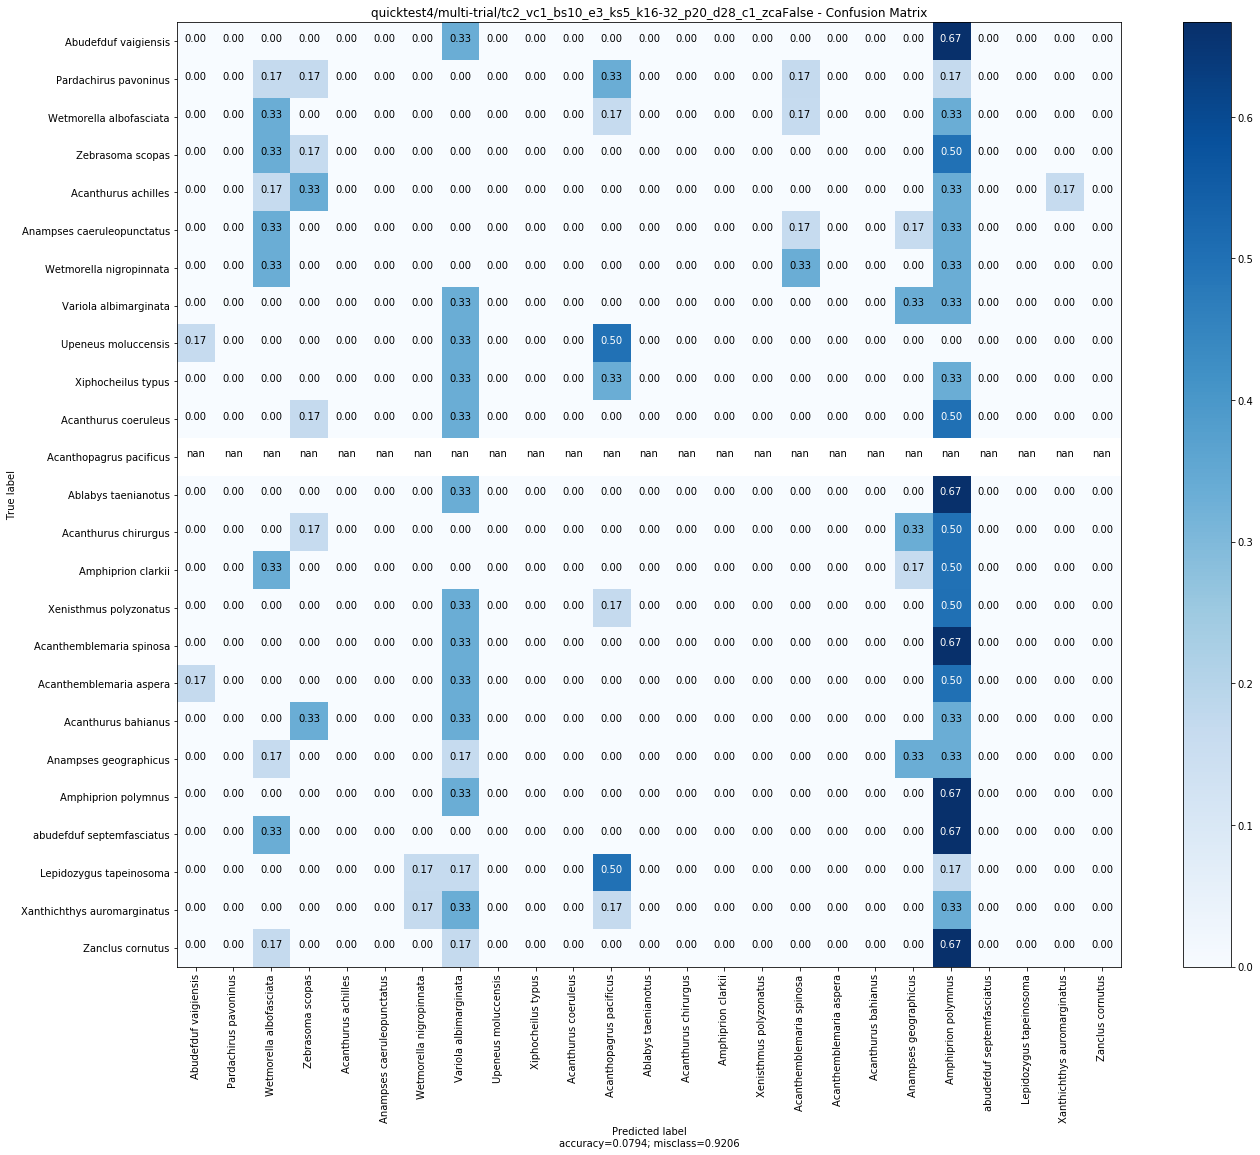

experiment:  {'image_path': './Fish_toy/images', 'training_count': 2, 'validation_count': 1, 'batchSize': 10, 'n_epochs': 3, 'numOfTrials': 3, 'kernels': [16, 32], 'kernelSize': 5, 'patience': 20, 'imageDimension': 28, 'n_channels': 1, 'useZCAWhitening': True}


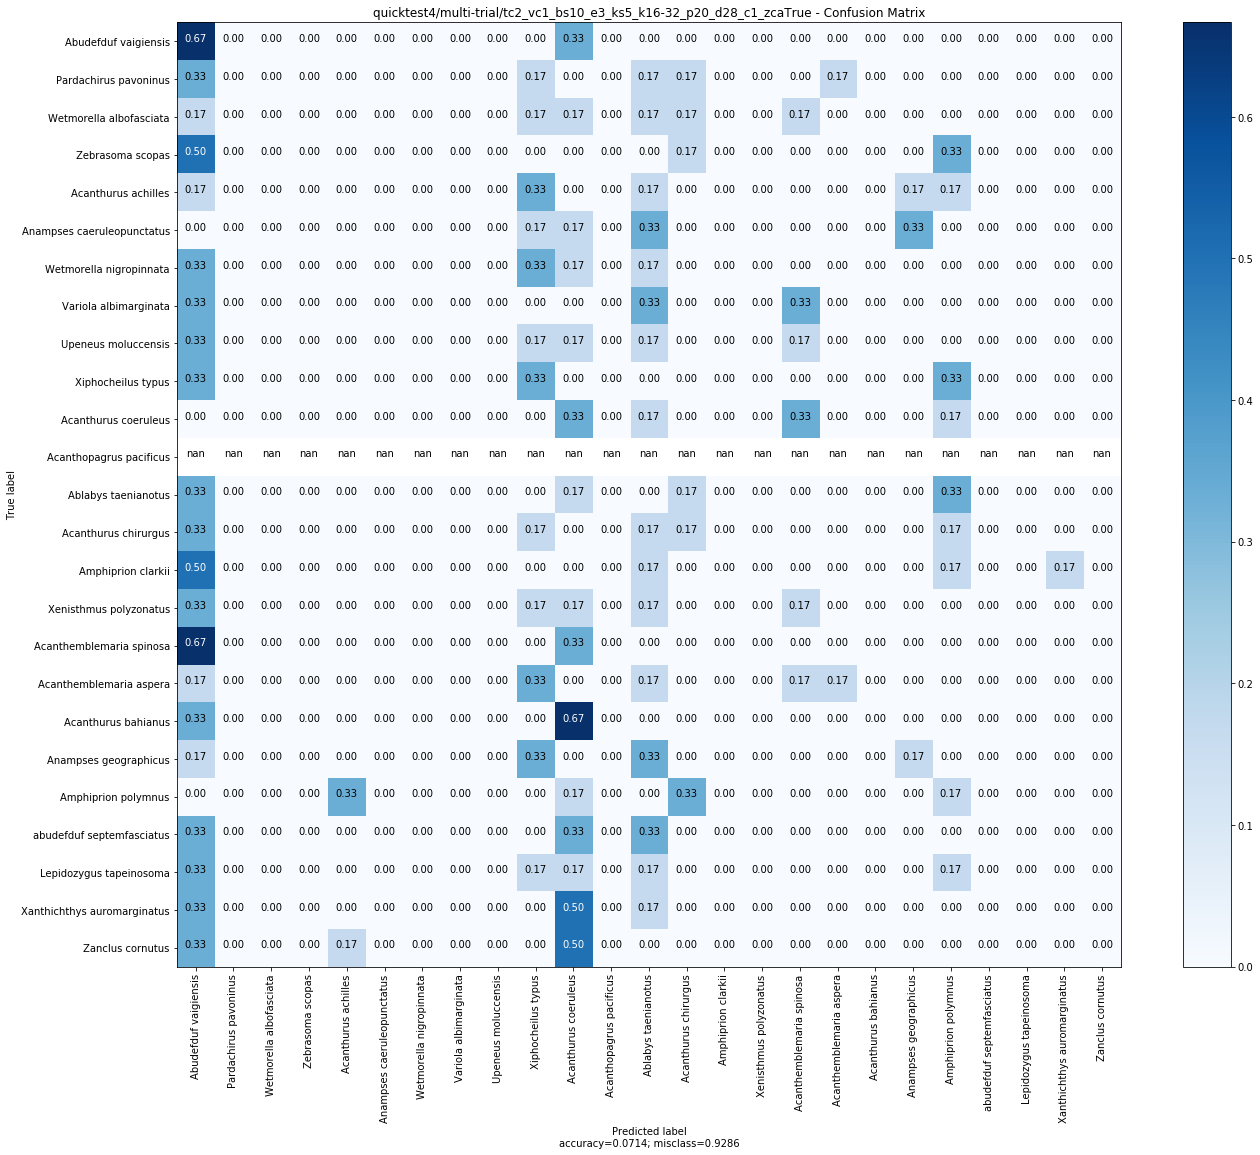

experiment:  {'image_path': './Fish_toy/images', 'training_count': 2, 'validation_count': 1, 'batchSize': 10, 'n_epochs': 3, 'numOfTrials': 3, 'kernels': [16, 32], 'kernelSize': 5, 'patience': 20, 'imageDimension': 28, 'n_channels': 3, 'useZCAWhitening': False}


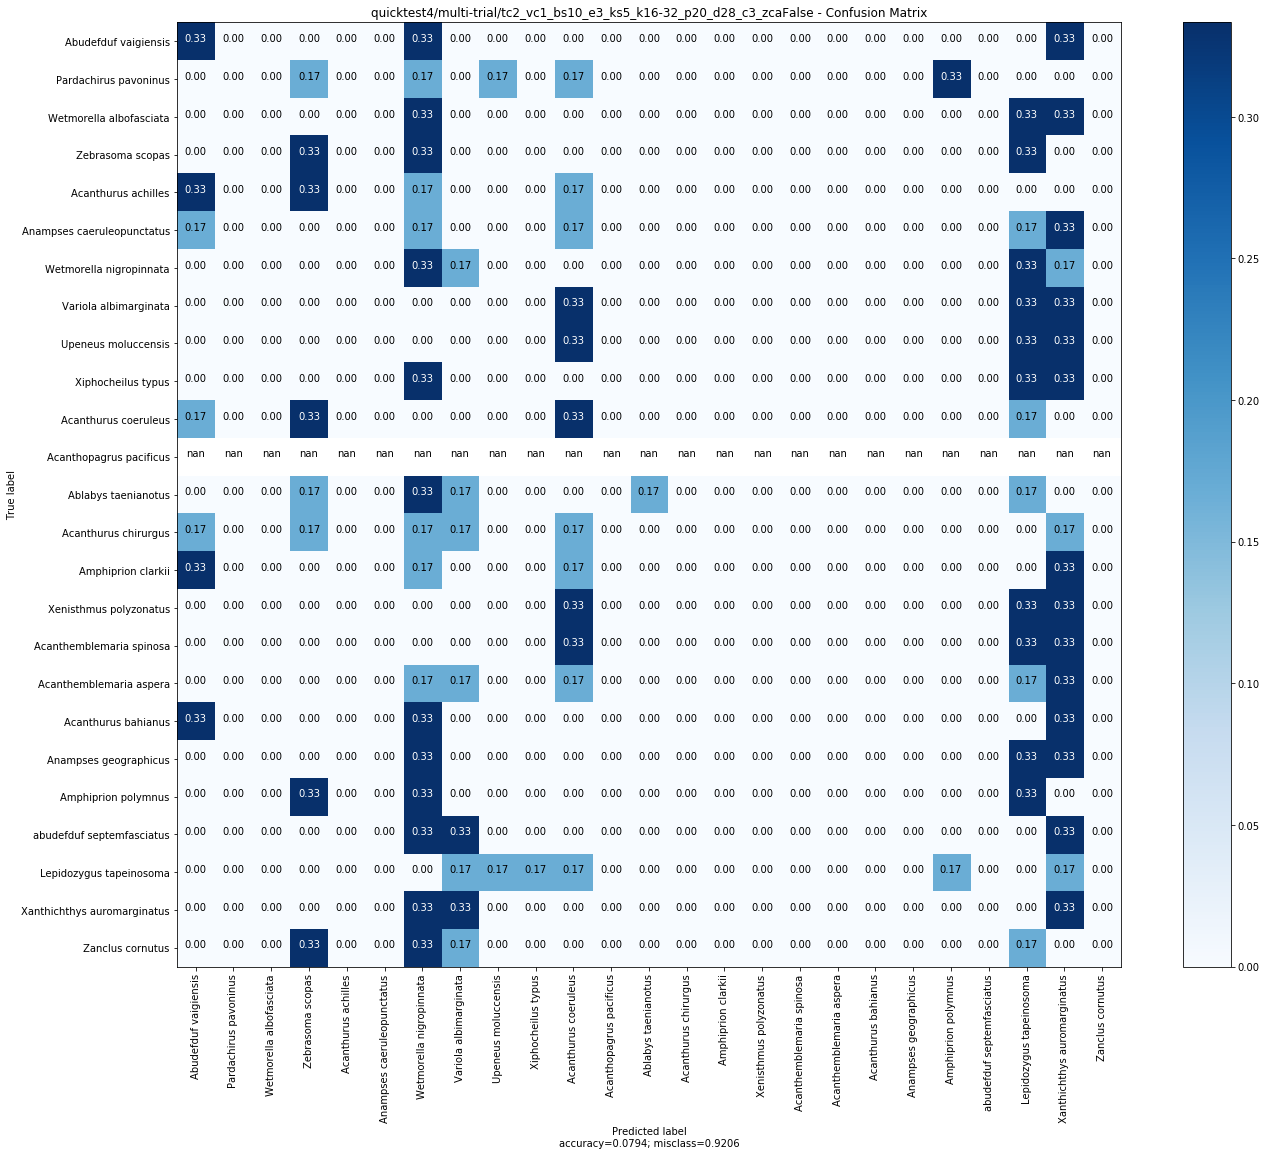

experiment:  {'image_path': './Fish_toy/images', 'training_count': 2, 'validation_count': 1, 'batchSize': 10, 'n_epochs': 3, 'numOfTrials': 3, 'kernels': [16, 32], 'kernelSize': 5, 'patience': 20, 'imageDimension': 28, 'n_channels': 3, 'useZCAWhitening': True}


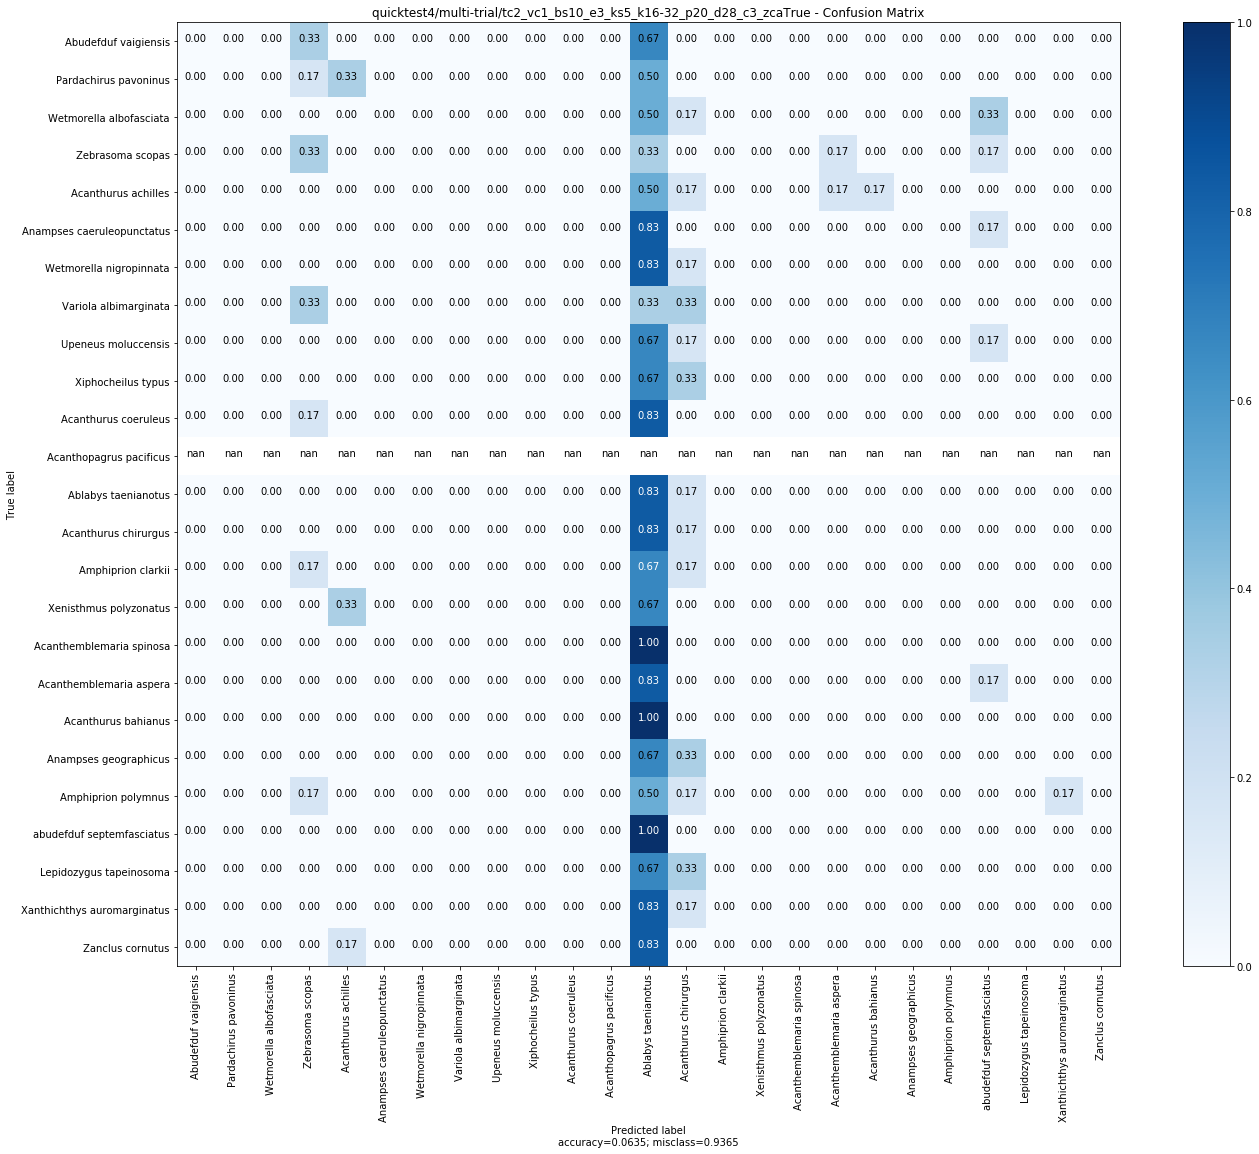

In [5]:
ts.showStatistics()
ts.showStatistics(False)
ts.saveStatistics()
ts.saveStatistics(False)

paramsIterator = config_parser.getHyperpIter() 
for experiment_params in paramsIterator:
    experiment_params["numOfTrials"] = experiment_params["numOfTrials"] or 1
    
    print("experiment: ", experiment_params)
    
    dataset = dataLoader.FishDataset(experiment_params, showListOfSpecies)
    speciesList = dataset.getSpeciesList()
    ts.printTrialConfusionMatrix(experiment_params, speciesList, True)